In [2]:
from Binaries import *

# For VEM Peak

-8/2399 /cr/tempdata01/filip/iRODS/corrected/peru_randoms0793.csv: 5000 traces


StopIteration: 

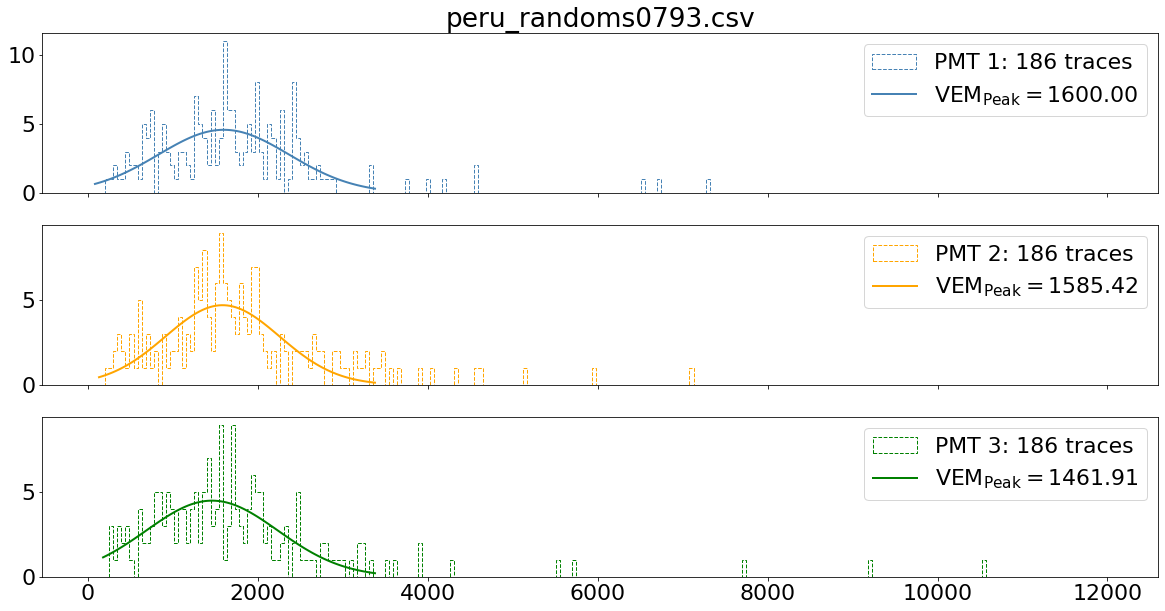

In [11]:
peak_evolution = []
cut_threshold = 60
trailing_bins = 50
leading_bins = 10

mode = "charge"

if mode == "peak":
    x_range = (cut_threshold, 1750)
    i, f = 10, 50
    func = max
elif mode == "charge":

    x_range = (cut_threshold, 12000)
    i, f = 0, 70
    func = sum


from scipy.optimize import curve_fit

def gauss(x, mu, A, sigma):

    return A * np.exp( -(x - mu)**2 / (2 * sigma**2) )

colors = ["steelblue", "orange", "green"]

for index in [-8]:

    Buffer = RandomTrace(index)
    h1, h2, h3 = [], [], []
    vem_peak = []

    print(f"{index}/{RandomTrace.all_n_files} {RandomTrace.baseline_dir + RandomTrace.all_files[index]}: {len(Buffer._these_traces)} traces" )

    fig, axes = plt.subplots(3, 1, sharex = True)
    axes[0].set_title(RandomTrace.all_files[index])
    name = RandomTrace.all_files[index].split("_")[0]

    station = np.array(Buffer._these_traces)
    pmt1, pmt2, pmt3 = station[:,0], station[:,1], station[:,2]
    cut_mask = np.logical_and(np.any(pmt1 > cut_threshold, axis = 1), np.any(pmt2 > cut_threshold, axis = 1), np.any(pmt3 > cut_threshold, axis = 1))

    for (p1, p2, p3) in zip(pmt1[cut_mask], pmt2[cut_mask], pmt3[cut_mask]):

        trigger_bin = np.argmax(p1 > cut_threshold)
        start = max(0, trigger_bin - leading_bins)
        stop = min(trigger_bin + trailing_bins, 2048)

        p1_data, p2_data, p3_data = p1[start : stop], p2[start : stop], p3[start : stop]

        if np.any(p2_data > cut_threshold) and np.any(p3_data > cut_threshold):

            h1.append(func(p1_data)), h2.append(func(p2_data)), h3.append(func(p3_data))
    
    for i, histogram in enumerate([h1, h2, h3]):

        n, bins, _ = axes[i].hist(histogram,  bins = 250, range = x_range, label = f"PMT {i + 1}: {len(histogram)} traces", ls = "--", histtype = "step", color = colors[i])
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        x, y = bin_centers[i : f], n[i : f]
        x_smooth = np.linspace(min(x), max(x), 100)

        popt, pcov = curve_fit(gauss, x, y, p0 = [x[np.argmax(y)], 10, sum(y)], bounds = ([0, 0, 0], [np.inf, np.inf, np.inf]) )
        model_fit = gauss(x_smooth, *popt)
        peak_estimate = popt[0]

        axes[i].plot(x_smooth, model_fit, lw = 2, label = r"$\mathrm{VEM}_\mathrm{Peak} = $" + f"{peak_estimate:.2f}", c = colors[i])
        axes[i].legend()

        vem_peak.append(peak_estimate)

    peak_evolution.append(vem_peak)
    
    raise StopIteration